<a href="https://colab.research.google.com/github/M4700F/CSE-4622-ML-Lab-Term-Project/blob/Maroof/adversarial_attack_on_machine_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from google.colab import drive
import random

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMG_SIZE = 224  # 224x224 as mentioned in paper
NUM_SAMPLES = 500

In [4]:
dataset_path = '/content/drive/MyDrive/data'
train_path = os.path.join(dataset_path, 'train')
test_path = os.path.join(dataset_path, 'test')

In [5]:
train_benign_path = os.path.join(train_path, 'benign')
train_malignant_path = os.path.join(train_path, 'malignant')
test_benign_path = os.path.join(test_path, 'benign')
test_malignant_path = os.path.join(test_path, 'malignant')

In [6]:
print("Checking dataset structure...")
print(f"Dataset folder exists: {os.path.exists(dataset_path)}")
print(f"Train folder exists: {os.path.exists(train_path)}")
print(f"Test folder exists: {os.path.exists(test_path)}")

Checking dataset structure...
Dataset folder exists: True
Train folder exists: True
Test folder exists: True


In [7]:
print("\nTrain folders:")
print(f"  Train/Benign exists: {os.path.exists(train_benign_path)}")
print(f"  Train/Malignant exists: {os.path.exists(train_malignant_path)}")

print("\nTest folders:")
print(f"  Test/Benign exists: {os.path.exists(test_benign_path)}")
print(f"  Test/Malignant exists: {os.path.exists(test_malignant_path)}")


Train folders:
  Train/Benign exists: True
  Train/Malignant exists: True

Test folders:
  Test/Benign exists: True
  Test/Malignant exists: True


In [8]:
train_benign_count = len([f for f in os.listdir(train_benign_path) if f.endswith('.jpg')])
print(f"  Train/Benign images: {train_benign_count}")

train_malignant_count = len([f for f in os.listdir(train_malignant_path) if f.endswith('.jpg')])
print(f"  Train/Malignant images: {train_malignant_count}")

test_benign_count = len([f for f in os.listdir(test_benign_path) if f.endswith('.jpg')])
print(f"  Test/Benign images: {test_benign_count}")

test_malignant_count = len([f for f in os.listdir(test_malignant_path) if f.endswith('.jpg')])
print(f"  Test/Malignant images: {test_malignant_count}")


  Train/Benign images: 1440
  Train/Malignant images: 1197
  Test/Benign images: 360
  Test/Malignant images: 300


### Load images

In [9]:
def load_images(folder_path, label, max_samples=500):
    images = []
    labels = []

    # Get all jpg files
    files = [f for f in os.listdir(folder_path) if f.endswith('.jpg')]

    # Randomly select max_samples files
    if len(files) > max_samples:
        files = random.sample(files, max_samples)

    print(f"Loading {len(files)} images from {folder_path.split('/')[-1]} folder...")

    for i, filename in enumerate(files):
        try:
            # Load and resize image
            img_path = os.path.join(folder_path, filename)
            img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
            img_array = img_to_array(img)
            img_array = img_array / 255.0  # Normalize to [0,1]

            images.append(img_array)
            labels.append(label)

            if (i + 1) % 100 == 0:
                print(f"  Processed {i + 1}/{len(files)} images")

        except Exception as e:
            print(f"  Error loading {filename}: {e}")
            continue

    return np.array(images), np.array(labels)

In [10]:
train_benign_images, train_benign_labels = load_images(train_benign_path, 0, NUM_SAMPLES)  # 0 for benign
train_malignant_images, train_malignant_labels = load_images(train_malignant_path, 1, NUM_SAMPLES)  # 1 for malignant

Loading 500 images from benign folder...
  Processed 100/500 images
  Processed 200/500 images
  Processed 300/500 images
  Processed 400/500 images
  Processed 500/500 images
Loading 500 images from malignant folder...
  Processed 100/500 images
  Processed 200/500 images
  Processed 300/500 images
  Processed 400/500 images
  Processed 500/500 images


In [12]:
# Combine training data
X_train = np.concatenate([train_benign_images, train_malignant_images], axis=0)
y_train = np.concatenate([train_benign_labels, train_malignant_labels], axis=0)

In [13]:
test_benign_images, test_benign_labels = load_images(test_benign_path, 0, NUM_SAMPLES)  # 0 for benign
test_malignant_images, test_malignant_labels = load_images(test_malignant_path, 1, NUM_SAMPLES)  # 1 for malignant

Loading 360 images from benign folder...
  Processed 100/360 images
  Processed 200/360 images
  Processed 300/360 images
Loading 300 images from malignant folder...
  Processed 100/300 images
  Processed 200/300 images
  Processed 300/300 images


In [14]:
# Combine test data
X_test = np.concatenate([test_benign_images, test_malignant_images], axis=0)
y_test = np.concatenate([test_benign_labels, test_malignant_labels], axis=0)

In [15]:
print(f"\n=== Dataset Summary ===")
print(f"Training set:")
print(f"  Total images: {len(X_train)}")
print(f"  Benign images: {np.sum(y_train == 0)}")
print(f"  Malignant images: {np.sum(y_train == 1)}")


=== Dataset Summary ===
Training set:
  Total images: 1000
  Benign images: 500
  Malignant images: 500


In [16]:
print(f"\nTest set:")
print(f"  Total images: {len(X_test)}")
print(f"  Benign images: {np.sum(y_test == 0)}")
print(f"  Malignant images: {np.sum(y_test == 1)}")


Test set:
  Total images: 660
  Benign images: 360
  Malignant images: 300


In [17]:
print(f"\nImage specifications:")
print(f"  Image shape: {X_train[0].shape}")
print(f"  Pixel value range: [{X_train.min():.3f}, {X_train.max():.3f}]")


Image specifications:
  Image shape: (224, 224, 3)
  Pixel value range: [0.000, 1.000]


In [18]:
# Step 10: Display sample images
def display_sample_images(X, y, title="Sample Images", num_samples=6):
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    axes = axes.ravel()

    for i in range(num_samples):
        idx = random.randint(0, len(X) - 1)
        img = X[idx]
        label = 'Malignant' if y[idx] == 1 else 'Benign'

        axes[i].imshow(img)
        axes[i].set_title(f'{label}')
        axes[i].axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


=== Displaying Sample Training Images ===


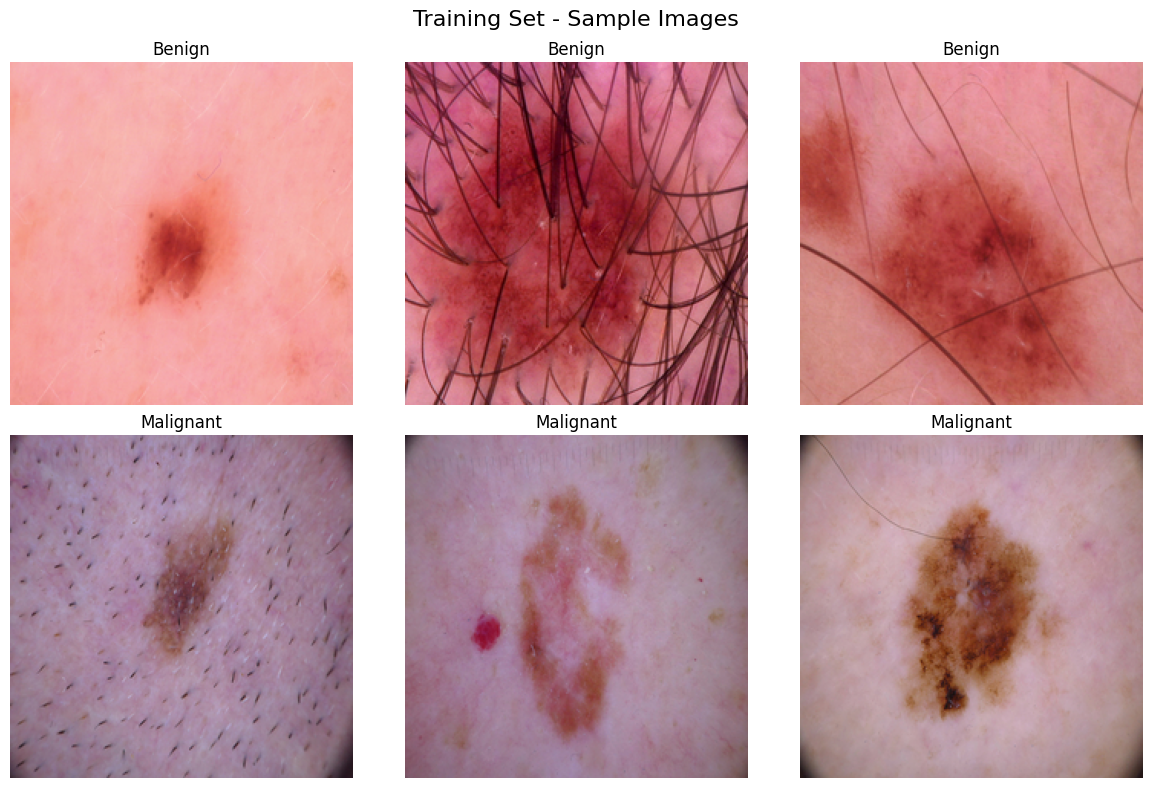


Dataset loading completed successfully!

Variables created:
- X_train: Training images
- X_test: Test images
- y_train: Training labels (0=benign, 1=malignant)
- y_test: Test labels (0=benign, 1=malignant)


In [19]:
# Display sample images from training set
print("\n=== Displaying Sample Training Images ===")
display_sample_images(X_train, y_train, "Training Set - Sample Images")

print("\nDataset loading completed successfully!")
print("\nVariables created:")
print("- X_train: Training images")
print("- X_test: Test images")
print("- y_train: Training labels (0=benign, 1=malignant)")
print("- y_test: Test labels (0=benign, 1=malignant)")

**Dataset Preparation**

In [20]:
# Import additional libraries
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [21]:
# Step 1: One-hot Encoding
print("1. Converting labels to one-hot encoding...")

# Create label encoder
label_encoder = LabelEncoder()

# Fit and transform training labels
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert to one-hot encoding (categorical)
y_train_onehot = to_categorical(y_train_encoded, num_classes=2)
y_test_onehot = to_categorical(y_test_encoded, num_classes=2)

print(f"Original labels shape: {y_train.shape}")
print(f"One-hot encoded labels shape: {y_train_onehot.shape}")
print(f"Label mapping: {dict(enumerate(label_encoder.classes_))}")

1. Converting labels to one-hot encoding...
Original labels shape: (1000,)
One-hot encoded labels shape: (1000, 2)
Label mapping: {0: np.int64(0), 1: np.int64(1)}


In [22]:
# Show examples
print(f"Example - Original: {y_train[:5]} -> One-hot: {y_train_onehot[:5]}")

Example - Original: [0 0 0 0 0] -> One-hot: [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [23]:
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train, y_train_onehot,
    test_size=0.3,           # 30% for validation
    random_state=42,
    stratify=y_train_encoded  # Stratified sampling to maintain class balance
)

In [25]:
print(f"Final training set: {len(X_train_final)} images")
print(f"Validation set: {len(X_val)} images")
print(f"Test set: {len(X_test)} images")

Final training set: 700 images
Validation set: 300 images
Test set: 660 images


In [26]:
# Check class distribution
print(f"\nClass distribution in final training set:")
print(f"  Benign: {np.sum(np.argmax(y_train_final, axis=1) == 0)}")
print(f"  Malignant: {np.sum(np.argmax(y_train_final, axis=1) == 1)}")


Class distribution in final training set:
  Benign: 350
  Malignant: 350


In [27]:
print(f"\nClass distribution in validation set:")
print(f"  Benign: {np.sum(np.argmax(y_val, axis=1) == 0)}")
print(f"  Malignant: {np.sum(np.argmax(y_val, axis=1) == 1)}")


Class distribution in validation set:
  Benign: 150
  Malignant: 150


In [30]:
#Data Augmentation
print("   Setting up data augmentation...")
print("   Rotation range: 15 degrees (as mentioned in paper)")

# Create data generators
# Training data generator with augmentation
train_datagen = ImageDataGenerator(
    rotation_range=15,        # Rotate images by up to 15 degrees
    width_shift_range=0.1,    # Shift images horizontally
    height_shift_range=0.1,   # Shift images vertically
    horizontal_flip=True,     # Flip images horizontally
    zoom_range=0.1,           # Zoom in/out
    shear_range=0.1,          # Shear transformation
    fill_mode='nearest',      # Fill missing pixels
    rescale=1.0               # Images are already normalized
)

   Setting up data augmentation...
   Rotation range: 15 degrees (as mentioned in paper)


In [31]:
# Validation and test data generators (no augmentation, only rescaling)
val_datagen = ImageDataGenerator(rescale=1.0)
test_datagen = ImageDataGenerator(rescale=1.0)

print("Data augmentation parameters:")
print(f"  - Rotation range: 15°")
print(f"  - Width/Height shift: 10%")
print(f"  - Horizontal flip: Yes")
print(f"  - Zoom range: 10%")
print(f"  - Shear range: 10%")

Data augmentation parameters:
  - Rotation range: 15°
  - Width/Height shift: 10%
  - Horizontal flip: Yes
  - Zoom range: 10%
  - Shear range: 10%


In [32]:
BATCH_SIZE = 32

In [33]:
# Training generator (with augmentation)
train_generator = train_datagen.flow(
    X_train_final, y_train_final,
    batch_size=BATCH_SIZE,
    shuffle=True
)

# Validation generator (no augmentation)
val_generator = val_datagen.flow(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Test generator (no augmentation)
test_generator = test_datagen.flow(
    X_test, y_test_onehot,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [34]:
print(f"   Data generators created with batch size: {BATCH_SIZE}")
print(f"   Training batches per epoch: {len(train_generator)}")
print(f"   Validation batches per epoch: {len(val_generator)}")
print(f"   Test batches: {len(test_generator)}")

   Data generators created with batch size: 32
   Training batches per epoch: 22
   Validation batches per epoch: 10
   Test batches: 21


   Displaying sample augmented images...


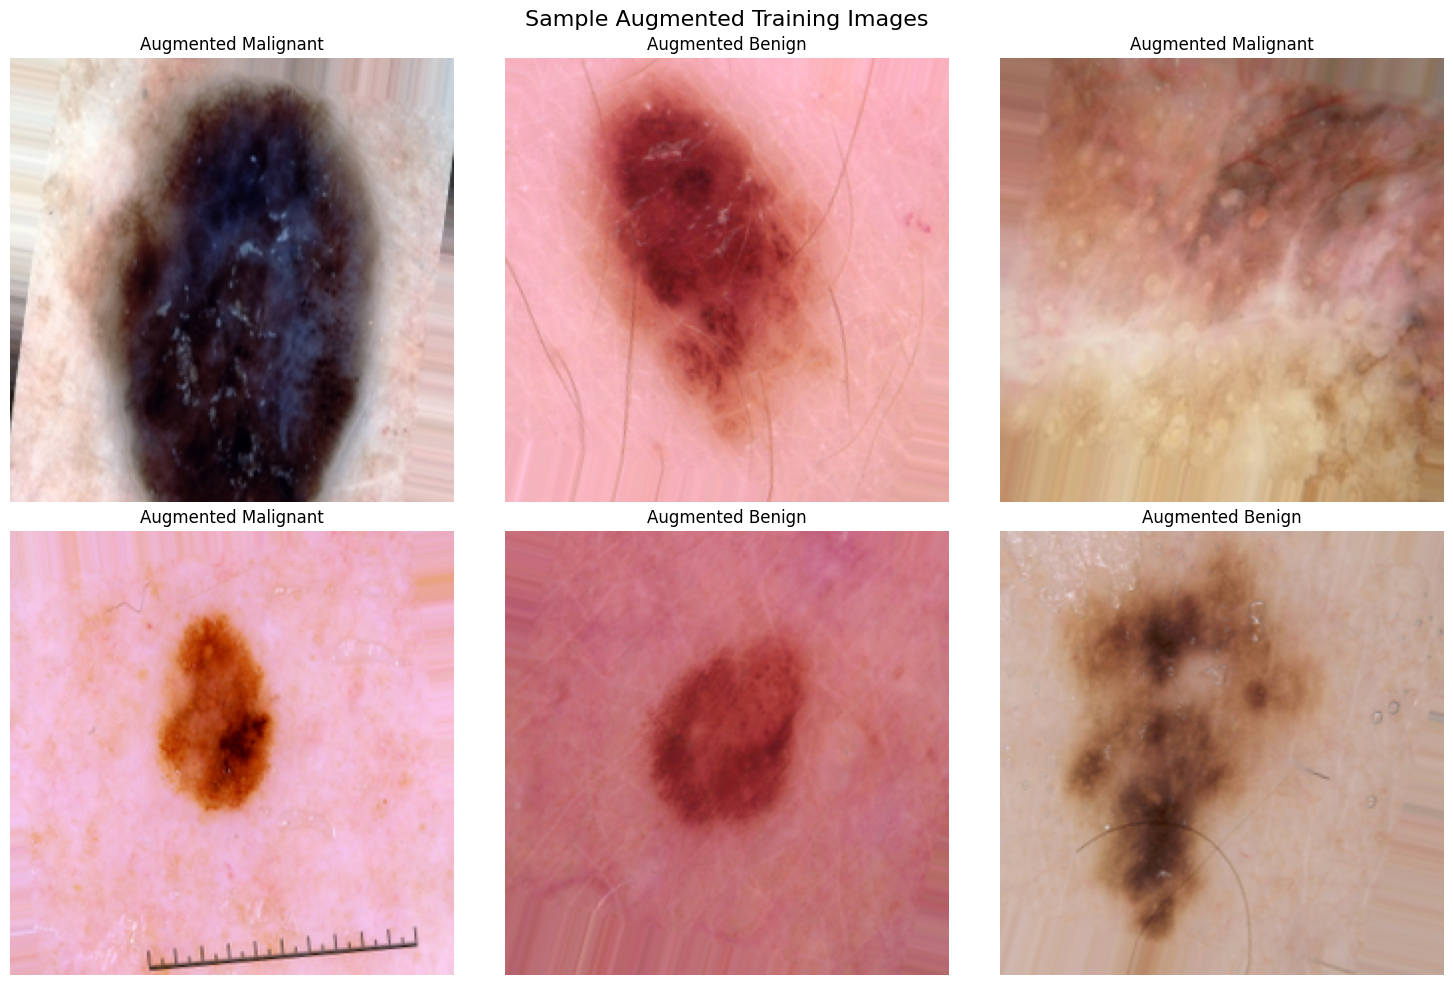

In [35]:
# Step 5: Visualize augmented images
import matplotlib.pyplot as plt

def show_augmented_images(generator, num_images=6):
    """Display original and augmented images"""
    # Get a batch from the generator
    batch_images, batch_labels = next(generator)

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.ravel()

    for i in range(min(num_images, len(batch_images))):
        img = batch_images[i]
        label = np.argmax(batch_labels[i])
        label_name = 'Malignant' if label == 1 else 'Benign'

        axes[i].imshow(img)
        axes[i].set_title(f'Augmented {label_name}')
        axes[i].axis('off')

    plt.suptitle('Sample Augmented Training Images', fontsize=16)
    plt.tight_layout()
    plt.show()

print("   Displaying sample augmented images...")
show_augmented_images(train_generator)

In [36]:
# Reset the generator
train_generator = train_datagen.flow(
    X_train_final, y_train_final,
    batch_size=BATCH_SIZE,
    shuffle=True
)

In [37]:
# Step 6: Summary
print("\n=== Dataset Preparation Summary ===")
print("✓ Labels converted to one-hot encoding")
print("✓ Data split using stratified sampling (70% train, 30% validation)")
print("✓ Data augmentation applied to training set")
print("✓ Data generators created for training, validation, and testing")
print("\nDataset is ready for VGG-19 model training!")

print("\nVariables available for next step:")
print("- train_generator: Training data with augmentation")
print("- val_generator: Validation data")
print("- test_generator: Test data")
print("- X_train_final, y_train_final: Final training arrays")
print("- X_val, y_val: Validation arrays")
print("- X_test, y_test_onehot: Test arrays with one-hot labels")


=== Dataset Preparation Summary ===
✓ Labels converted to one-hot encoding
✓ Data split using stratified sampling (70% train, 30% validation)
✓ Data augmentation applied to training set
✓ Data generators created for training, validation, and testing

Dataset is ready for VGG-19 model training!

Variables available for next step:
- train_generator: Training data with augmentation
- val_generator: Validation data
- test_generator: Test data
- X_train_final, y_train_final: Final training arrays
- X_val, y_val: Validation arrays
- X_test, y_test_onehot: Test arrays with one-hot labels
